In [12]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from models.elasticity_GINOT import LoadModel
from models import configs
from torch.utils.data import DataLoader
from tqdm import tqdm
import time
import json
device = "cuda" if torch.cuda.is_available() else "cpu"



In [13]:
configs_load = configs.elasticity_GINOT_configs()

filebase = configs_load["filebase"]
trunk_args = configs_load["trunk_args"]
branch_args = configs_load["branch_args"]
ginot = LoadModel(filebase, branch_args, trunk_args)
print("filebase: ", filebase)
print("trunk_args: ", trunk_args)
print("branch_args: ", branch_args)



Total number of parameters of Geo encoder: 225216, 225216 of which are trainable
Total number of parameters of NTO model: 543169, 543169 of which are trainable
filebase:  /work/hdd/bdsy/qibang/repository_Wbdsy/GINOT/models/saved_weights/elasticity_ginot
trunk_args:  {'embed_dim': 64, 'cross_attn_layers': 6}
branch_args:  {'out_c': 64, 'latent_d': None, 'width': 64, 'n_point': 64, 'n_sample': 18, 'radius': 0.2, 'd_hidden': [64, 64], 'num_heads': 4, 'cross_attn_layers': 1, 'self_attn_layers': 2, 'fps_method': 'fps'}


In [14]:

_, test_dataset, s_inverse = configs.LoadDataElasticityGeo()
# train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=512, shuffle=False)



In [15]:


def predict(data_loader, ginot):
    y_pred = []
    y_true = []
    verts_all = []
    pc_all = []
    ginot.eval()
    with torch.no_grad():
        for data in tqdm(data_loader, desc="Predicting"):
            pc = data[0].to(device)  # (B, N, 2)
            xyt = data[1].to(device)  # (B, N, 2)
            y_true_batch = data[2]  # (B, N)
            pred = ginot(xyt, pc)
            y_pred.append(pred.cpu().numpy())
            y_true.append(y_true_batch.cpu().numpy())
            verts_all.append(xyt.cpu().numpy())
            pc_all.append(pc.cpu().numpy())
        y_pred = np.concatenate(y_pred, axis=0)
        y_true = np.concatenate(y_true, axis=0)
        verts_all = np.concatenate(verts_all, axis=0)
        pc_all = np.concatenate(pc_all, axis=0)
    return s_inverse(y_pred), s_inverse(y_true), verts_all, pc_all


def plot_results(pc, verts, u_true, u_pred):
    fig, axes = plt.subplots(1, 4, figsize=(16, 4), gridspec_kw={
        'width_ratios': [1, 1, 1, 1.]})
    error = np.abs(u_true - u_pred)
    cmap = "jet"
    alpha = 0.9
    # Plot pc
    axes[0].scatter(pc[:, 0], pc[:, 1], c='blue', alpha=alpha)
    axes[0].set_title("Boundary PC")
    axes[0].set_aspect('equal', 'box')

    # Define shared color normalization for u_true and u_pred
    vmin, vmax = min(u_true.min(), u_pred.min()), max(
        u_true.max(), u_pred.max())

    # Plot u_true
    sc1 = axes[1].scatter(verts[:, 0], verts[:, 1], c=u_true,
                          cmap=cmap, alpha=alpha, vmin=vmin, vmax=vmax)
    axes[1].set_title("Truth")
    axes[1].set_aspect('equal', 'box')
    # Plot u_pred
    sc2 = axes[2].scatter(verts[:, 0], verts[:, 1], c=u_pred,
                          cmap=cmap, alpha=alpha, vmin=vmin, vmax=vmax)
    axes[2].set_title("Pred.")
    axes[2].set_aspect('equal', 'box')
    # Plot absolute error
    sc3 = axes[3].scatter(verts[:, 0], verts[:, 1],
                          c=error, cmap=cmap, alpha=alpha)
    axes[3].set_title("Abs.Error")
    axes[3].set_aspect('equal', 'box')
    # Adjust subplot layout manually
    plt.subplots_adjust(wspace=0.3, right=0.88)  # wspace controls spacing between subplots, right leaves space for colorbars

    # Create colorbars on the right of the fourth plot
    # Position for shared u_true/u_pred colorbar
    cbar_ax1 = fig.add_axes([0.93, 0.15, 0.02, 0.7])
    # Position for error colorbar
    cbar_ax2 = fig.add_axes([0.98, 0.15, 0.02, 0.7])
    cbar1 = fig.colorbar(sc1, cax=cbar_ax1)
    cbar1.set_label("Stress")  # Title for shared colorbar
    cbar1.ax.yaxis.set_label_position('left')  # Move label to the left
    # Optional: Move ticks to the left as well
    cbar1.ax.yaxis.set_ticks_position('left')

    cbar2 = fig.colorbar(sc3, cax=cbar_ax2)
    cbar2.set_label("Abs. Error")  # Title for error colorbar
    cbar2.ax.yaxis.set_label_position('left')  # Move label to the left
    # Optional: Move ticks to the left as well
    cbar2.ax.yaxis.set_ticks_position('left')
    # Adjust layout
    # plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space for colorbars


def cal_l2_error(y_pred, y_true):

    error_s = []
    for y_p, y_t in zip(y_pred, y_true):
        s_p, s_t = y_p[:], y_t[:]
        e_s = np.linalg.norm(s_p-s_t)/np.linalg.norm(s_t)
        error_s.append(e_s)
    error_s = np.array(error_s)
    return error_s



In [16]:
# test data
time_start = time.time()
s_pred_test, s_true_test, verts_all_test, pc_all_test = predict(
    test_dataloader, ginot)
time_end = time.time()
print(f"Time taken to predict all samples: {time_end-time_start:.2e} seconds")
print(
    f"Time taken to predict one sample: {(time_end-time_start)/len(s_pred_test):.2e} seconds")



Predicting: 100%|██████████| 1/1 [00:00<00:00, 13.43it/s]

Time taken to predict all samples: 7.71e-02 seconds
Time taken to predict one sample: 3.86e-04 seconds


Mean L2 error of test dataset: 0.013323817402124405, std: 0.004538992419838905


Text(0, 0.5, 'Frequency')

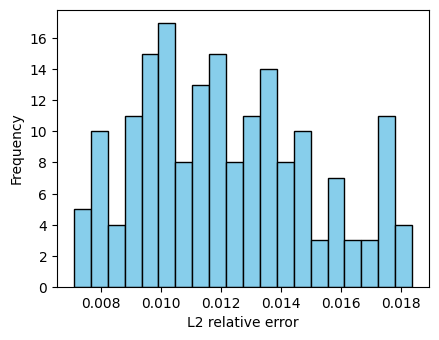

In [17]:
# overall performance on all test samples
error_s = cal_l2_error(s_pred_test, s_true_test)
sort_idx = np.argsort(error_s)
mean, std = np.mean(error_s), np.std(error_s)
print(f"Mean L2 error of test dataset: {mean}, std: {std}")
fig = plt.figure(figsize=(4.8, 3.6))
ax = plt.subplot(1, 1, 1)
_ = ax.hist(error_s[sort_idx[:-20]], bins=20,
            color="skyblue", edgecolor="black")
ax.set_xlabel("L2 relative error")
ax.set_ylabel("Frequency")



L2 realtive error of the best test sample: 0.007096442393958569


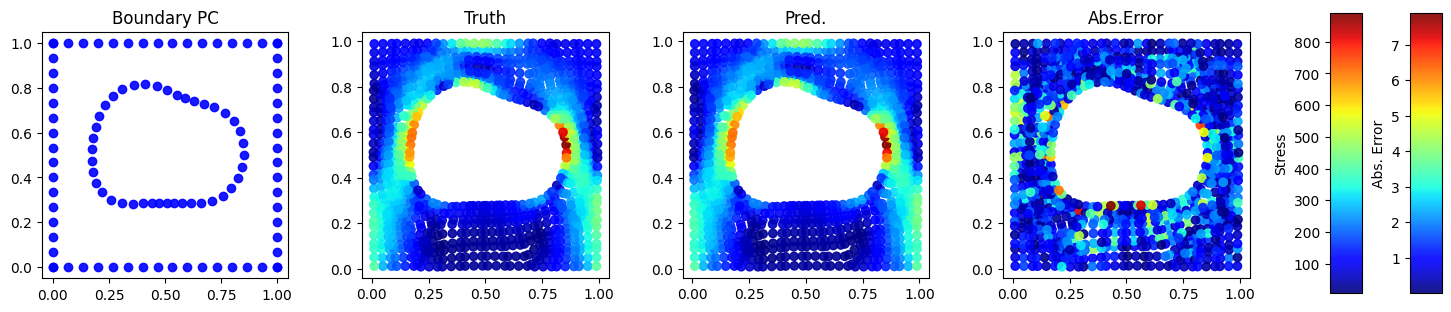

In [18]:
# plot the best sample
index = sort_idx[0]
print(
    f"L2 realtive error of the best test sample: {error_s[index]}")
verts_test = verts_all_test[index]
surface_pc_test = pc_all_test[index]
True_s_test = s_true_test[index]
Pred_s_test = s_pred_test[index]
plot_results(surface_pc_test, verts_test, True_s_test, Pred_s_test)


L2 realtive error of the 50 percentile test sample: 0.012209523469209671


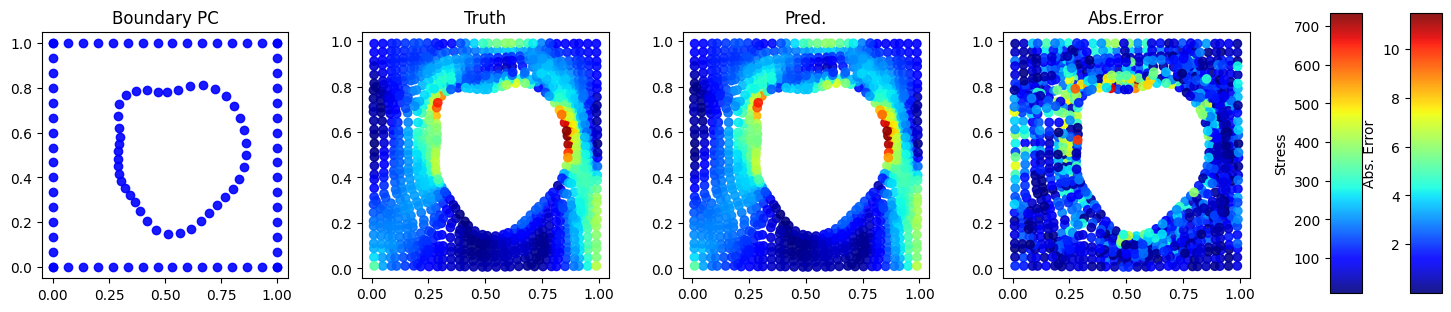

In [19]:
# plot the median sample
index = sort_idx[int(len(sort_idx)*0.5)-2]
print(
    f"L2 realtive error of the 50 percentile test sample: {error_s[index]}")
verts_test = verts_all_test[index]
surface_pc_test = pc_all_test[index]
True_s_test = s_true_test[index]
Pred_s_test = s_pred_test[index]
plot_results(surface_pc_test, verts_test, True_s_test, Pred_s_test)

L2 realtive error of the 95 percentile test sample: 0.02308531478047371


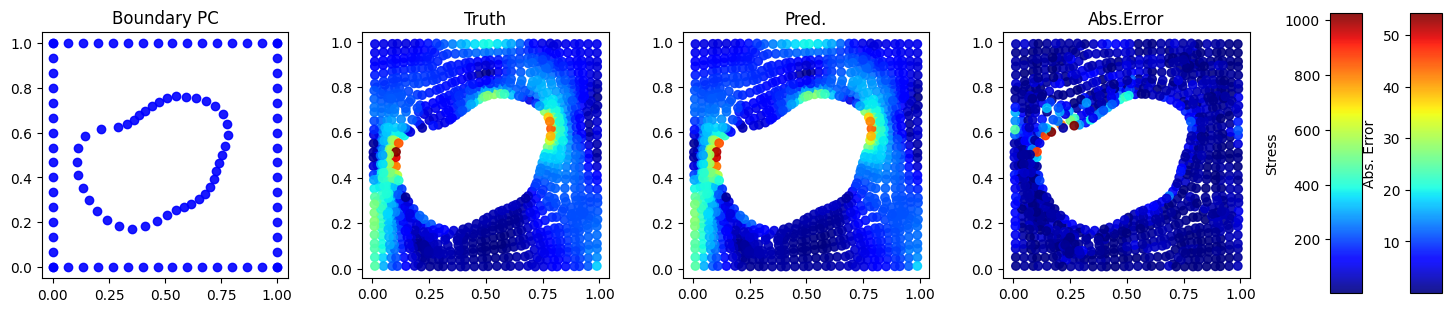

In [20]:
# plot the worst sample
index = sort_idx[int(len(sort_idx)*0.95)-1]
print(
    f"L2 realtive error of the 95 percentile test sample: {error_s[index]}")
verts_test = verts_all_test[index]
surface_pc_test = pc_all_test[index]
True_s_test = s_true_test[index]
Pred_s_test = s_pred_test[index]
plot_results(surface_pc_test, verts_test, True_s_test, Pred_s_test)

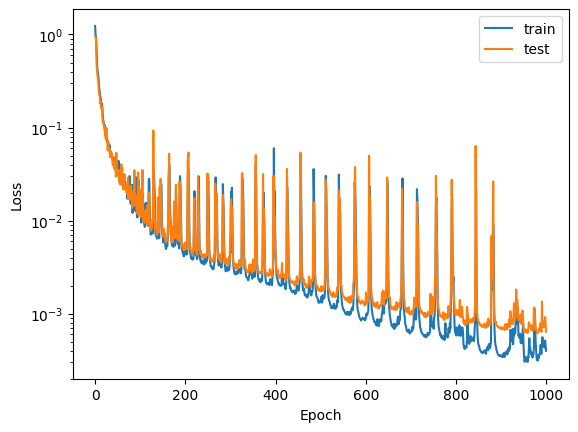

In [21]:
loss_file = filebase + "/logs.json"
with open(loss_file, 'r') as f:
    data = json.load(f)
plt.plot(data['loss'], label='train')
plt.plot(data['val_loss'], label='test')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()



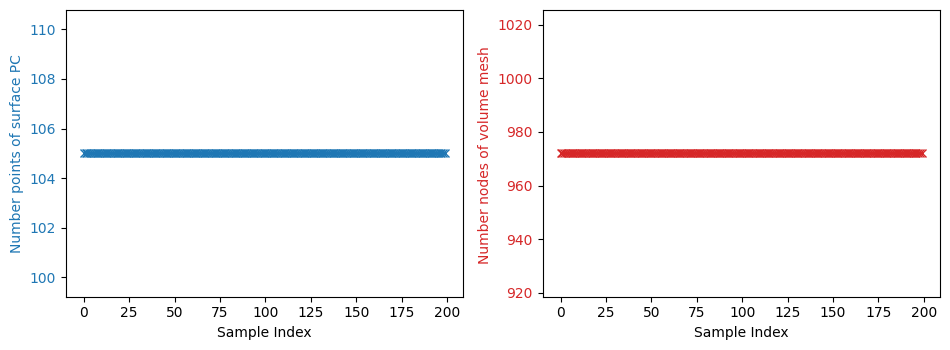

In [22]:
num_pc_point = [x.shape[0] for x in pc_all_test]
num_query_points = [len(x) for x in verts_all_test]
fig = plt.figure(figsize=(4.8*2, 3.6))
ax1 = plt.subplot(1, 2, 1)
color = 'tab:blue'
ax1.set_xlabel('Sample Index')
ax1.set_ylabel('Number points of surface PC', color=color)
ax1.plot(num_pc_point, 'x', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = plt.subplot(1, 2, 2)
color = 'tab:red'
ax2.set_xlabel('Sample Index')
ax2.set_ylabel('Number nodes of volume mesh ', color=color)
ax2.plot(num_query_points, 'x', color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()
